In [10]:
import numpy as np
import h5py
from sklearn.metrics import accuracy_score

In [7]:
def load_OASIS():
     with h5py.File('..\..\Datasets\OASIS_balanced.h5', 'r') as hdf:
        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))
        return trainX, trainY, testX, testY

In [9]:
def load_ADNI():
    with h5py.File('..\..\Datasets\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [8]:
dataset = 'ADNdI'
# read the data which is also normalized.
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(8192, 176, 176) (8192,) (2560, 176, 176) (2560,)


In [5]:
# make it 3D (for VGG16)
if dataset == 'ADNI':
    x_train = np.repeat(x_train, 3, axis=3)
    x_test = np.repeat(x_test, 3, axis=3)
else:
    x_train = np.expand_dims(x_train, axis=-1)
    x_train = np.repeat(x_train, 3, axis=3)
    x_test = np.expand_dims(x_test, axis=-1)
    x_test = np.repeat(x_test, 3, axis=3)
print('x_train shape:', x_train.shape)

x_train shape: (8192, 176, 176, 3)


In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
if dataset == 'ADNI':
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(218, 182, 3))
else:
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
# Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [7]:
# Now, let us use features from convolutional network for KNN
print("extracting VGG16 features")
feature_extractor=VGG_model.predict(x_train)
print("reshaping features")
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
# print(feature_extractor.shape)
# print(features.shape)
X_Train = features #This is our X input to Logistic Regression.
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_Test = X_test_feature.reshape(X_test_feature.shape[0], -1)
print(X_Test.shape)
print(X_Train.shape)

extracting VGG16 features
reshaping features
(2560, 12800)
(8192, 12800)


In [8]:
print("model-1:KNN")
from sklearn.neighbors import KNeighborsClassifier
model1_KNN = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)

# print('Train the model on training data')
# model1_KNN.fit(X_Train, y_train) # For sklearn no one hot encoding

# print("predicting")
# # Now predict using the trained RF model.
# prediction1 = model1_KNN.predict(X_Test)

model-1:KNN


In [9]:
print('model-2')
from sklearn import svm
model2_SVM = svm.SVC(kernel='linear',C=1, probability=True, random_state=42)

# print('Train the model')
# model2_SVM.fit(X_Train, y_train)

# print ('Predicting')
# prediction2 = model2_SVM.predict(X_Test)



model-2


In [58]:
print('model-3')
import xgboost as xgb
model3_XGB = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100)

# print('Train the model')
# model3_XGB.fit(X_Train, y_train)  # For sklearn no one hot encoding

# print ('Predicting')
# prediction3 = model3_XGB.predict(X_Test)

model-3


In [59]:
print('model-4')
from sklearn.linear_model import LogisticRegression
model4_LogReg = LogisticRegression(solver = 'liblinear')

# print('Train the model')
# model4_LogReg.fit(X_Train, y_train)

# print ('Predicting')
# prediction4 = model4_LogReg.predict(X_Test)

model-4


In [60]:

# print('KNN accuracy:', accuracy_score(y_test, prediction1))

# print('SVM accuracy:', accuracy_score(y_test, prediction2))

# print('XGBoost accuracy:', accuracy_score(y_test, prediction3))

# print('Logistic regression accuracy:', accuracy_score(y_test, prediction4))



In [13]:
from sklearn.ensemble import VotingClassifier
#model = VotingClassifier(estimators=[('knn', model1_KNN), ('svm', model2_SVM), ('XGB',model3_XGB), ('LogReg', model4_LogReg)], voting='soft')
#model = VotingClassifier(estimators=[('knn', model1_KNN), ('svm', model2_SVM),('LogReg',model4_LogReg),('XGB', model3_XGB)], voting='hard')
model = VotingClassifier(estimators=[('svm',model2_SVM),('knn',model1_KNN)], voting='soft')
#model = VotingClassifier(estimators=[('knn', model1_KNN), ('xgb', model3_XGB)], voting='soft')
model=model.fit(X_Train, y_train)

print('Ensemble Accuracy:', model.score(X_Test,y_test))

Ensemble Accuracy: 0.965234375


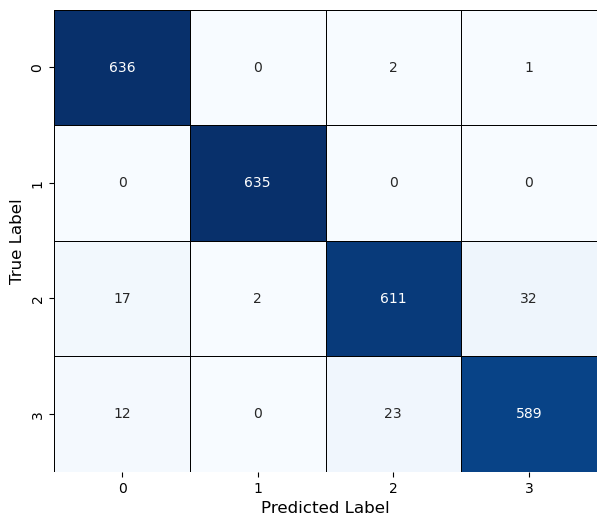

In [15]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
prediction = model.predict(X_Test)


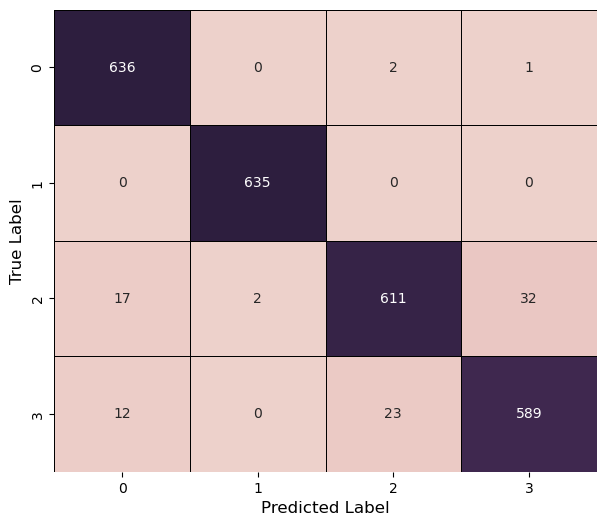

In [17]:
cf_matrix = confusion_matrix(y_test, prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM-Ensemble-OASIS.pdf")